# Coherence Tutorial.  

### The goal of this tutorial is to practice estimating the Noise and Signal from a neural response.
### The signal is the mean response.  This mean response is also what is predicted in the context of GLMs.  GLMs predict the mean of a Noise distribution (generally Normal, Poisson or Binomial).  
### By estimating the mean and the noise directly from the data one can obtain the ceiling value of that can be predicted.  
### The coherence is a measure of signal to noise ratio as a function of frequency.



## Dependencies

In [166]:
%matplotlib inline

from glob import glob
import mne
from scipy.io import wavfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from numpy.fft import fftshift, ifft, fft, fftfreq

from mnespikes import Neuron
plt.ion()

The next three sections allow you to load and visualize single unit data from
The theunissen lab. Your goals are:

1. Get familiar with this data structure
2. Load you own data in a similar structure.

For the Theunissen data you can specify a directory for three brain regions and three example neurons in each.: 'mld' is the avian auditory midbrain 'ov' is the avian auditory thalamus 'l2a' is the avian auditory cortex each region has a 'good', 'avg', and 'bad' dataset, corresponding to the signal to noise ratio, quantified by information values.

In the next few cells we are reading all of the data and storing it in a pandas data frame.
The data consists of stimulus-response pairs.  Here there are 10 trials per stimulus and therefore the same stimulus is used multiple times.  We are also going to select the stimulus/response files corresponding to conspecific song. 

To use this code on your own data, you will need to write your own data load function for your data.

### Set up the path

In [2]:
# Change this if you move around files
path_base = os.path.join('../../')

# For example you can specify an entire path
path_base = '/Users/frederictheunissen/Documents/Classes/Summer Course/2016/theunissen_tutorials'

data_files = glob(os.path.join(path_base, 'data', '*', '*', '*'))
# spikes = glob('../data/*/*/*')

### Read the data and store it into a pandas data frame

In [3]:
columns = ['location', 'quality', 'kind', 'number']
stims = {name: [] for name in columns}
stims['path'] = []
spikes = {name: [] for name in columns}
spikes['spike_times'] = []

 
for dfile in data_files:
    if 'stim' in dfile:
        prefix = 'stim'
    elif 'spike' in dfile:
        prefix = 'spike'
    else:
        # Skip because it's not a stim or spike file
        continue
    with open(dfile, 'r') as ff:
        # Pull metadata
        location_quality, kind, number = dfile.split(os.sep)[-3:]
        location, quality = location_quality.split('_')
        stimnumber = int(number.replace(prefix, ''))
        
        if prefix == 'stim':
            dpath = ff.read().strip()
            this_columns = columns + ['path']
            iter_data = [location, quality, kind, stimnumber, dpath]
            for column, data in zip(this_columns, iter_data):
                stims[column].append(data)
        elif prefix == 'spike':
            with open(dfile, 'r') as ff:
                spike_times = ff.readlines()
                spike_times = [ii.strip() for ii in spike_times]
                spike_times_float = []
                for trial in spike_times:
                    if len(trial) > 0:
                        this_times = np.array(trial.split(' '), dtype=float)
                    else:
                        this_times = np.array([])
                    spike_times_float.append(this_times)
            this_columns = columns + ['spike_times']
            iter_data = [location, quality, kind, stimnumber, spike_times_float]
            for column, data in zip(this_columns, iter_data):
                spikes[column].append(data)

stims = pd.DataFrame(stims)
spikes = pd.DataFrame(spikes)
data = pd.merge(stims, spikes)

In [4]:
# Expand the data so that each row is a single instance
tmp_data = []
for ii, row in data.iterrows():
    for jj, trial in enumerate(row['spike_times']):
        this_data = row.copy()
        this_data['spike_times'] = trial
        this_data['repetition'] = jj
        tmp_data.append(this_data)
data = pd.DataFrame(tmp_data)
data = data.drop('number', axis=1)

# Finally convert all spike times to seconds (they are currently in milliseconds)
data['spike_times'] = data['spike_times'].apply(lambda a: [ii / 1e3 for ii in a])

In [5]:
# Displaying the panda data frame.
data

,kind,location,path,quality,spike_times,repetition
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.020156, 0.032031, 0.216187, 0.449343, 0.449...",0
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.01675, 0.031718, 0.079906, 0.126468, 0.2015...",1
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.016125, 0.103218, 0.152906, 0.241218, 0.276...",2
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.103843, 0.362, 0.451031, 0.504843, 0.561437...",3
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.021937, 0.035031, 0.070843, 0.112437, 0.127...",4
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.056187, 0.074812, 0.196718, 0.454781, 0.506...",5
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.506812, 0.591593, 0.647937, 0.713656, 1.035...",6
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.128562, 0.45475, 0.502218, 0.567156, 0.8016...",7
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,"[0.281062, 0.297656, 0.352562, 0.415468, 0.507...",8
0,conspecific,l2a,D54ABC42488F995C789F351A34316039.wav,avg,[1.521625],9


# Preprocess audio

Here we are going to calculate a spectrogram for each unique sound file.  We are going to do this using the time-frequency routines from mne: Check out https://www.martinos.org/mne/stable/generated/mne.time_frequency.tfr_array_morlet.html#mne.time_frequency.tfr_array_morlet

Note - for spiking data there are 10 repetitions of audio for each file. This corresponds to a single audio file, which we'll load in here in order to calculate the spectrogram of each.

In [6]:
all_audio_files = data['path'].unique()

freqs = np.logspace(np.log10(500), np.log10(10000), 50)  # The frequencies that will be extracted
decimate = 32  # How much do we wish to decimate the resulting spectrogram

spectrograms = {}
for audio_file in tqdm(all_audio_files):
    sfreq_audio, audio = wavfile.read(os.path.join(path_base, 'data', 'all_stims', audio_file))
    time_audio = np.arange(audio.shape[0]) / float(sfreq_audio)
    
    tfr = mne.time_frequency.tfr_array_morlet(audio[np.newaxis, np.newaxis, :], sfreq_audio, freqs, decim=decimate)
    sfreq_audio /= decimate
    spectrograms[audio_file] = tfr

100%|██████████| 104/104 [00:26<00:00,  3.06it/s]


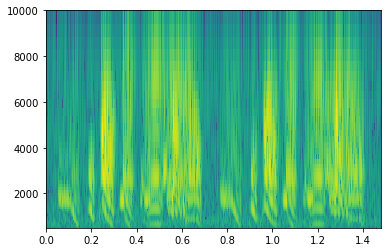

In [7]:
# Plot a spectrogram of a single stimulus as an example.  Here we choose the 4th stim.

plt_audio = spectrograms[all_audio_files[3]].squeeze()
time_audio = np.arange(plt_audio.shape[1]) / float(sfreq_audio)
plt.pcolormesh(time_audio, freqs, np.log(np.abs(plt_audio)))

## Chris and FET: Could have a nice spectrogram plot - using soundsig plotter??


# Preprocess spikes
Neuronal spiking data is essentially a collection of times, with each timepoint corresponding to one spike. Each spike file contains multiple repetitions of the same stimulus. These spikes are all from the same neuron

In [8]:
# We are going to look at the data from one neuron from l2a that has poor signal to noise ratio.
this_data = data.query('quality == "bad" and location == "l2a"')
spikes = this_data['spike_times'].values
event_types = this_data['kind'].values

## Chris, we should have a little exaplanation of this Neuron data structure...
neuron = Neuron(spikes, sfreq=1000.0, events=event_types,
                length=5., name='neuron_{}'.format(ii))

In [9]:
epochs = neuron.to_mne()
# The 500 events correspond to 10 trials to 20 different song (conspecific), 10 trials to 10 different ml noise
# and 10 trials to 20 ml noise with bird spectra.

500 matching events found
0 projection items activated
0 bad epochs dropped


In [10]:
epochs

<EpochsArray  |  n_events : 500 (all good), tmin : 0.0 (s), tmax : 4.999 (s), baseline : None, ~19.1 MB, data loaded,
 'conspecific': 200, 'flatrip': 100, 'songrip': 200>

[(0, 0.25)]

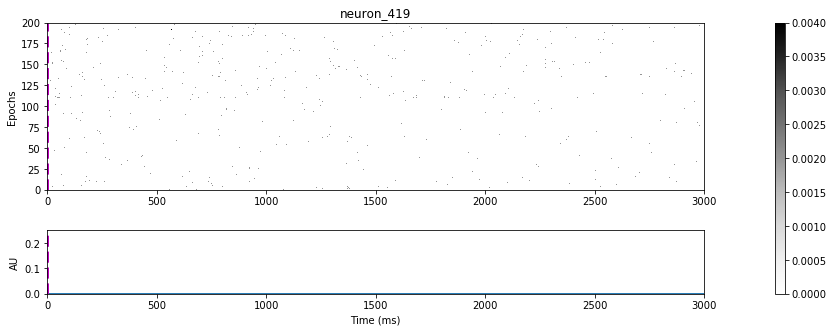

In [11]:
### Chris: can you explain what we are plotting here?
# I see that the first are spike raters - what is the second?
# what does .crop do?  and plot_image([0],..,...) - I guess I can read it in mne
# We might think of something more visually appealing and closer to what is in the matlab tutorials?

fig = epochs[['conspecific']].crop(0, 3).plot_image([0], show=False, vmin=0, cmap='Greys')
fig[0].set_size_inches(15, 5)
fig[0].axes[1].set(ylim=[0, .25])

# Firing rate

In [12]:
epochs._data = mne.filter.filter_data(epochs._data, epochs.info['sfreq'], None, 5)

Setting up low-pass filter at 5 Hz
h_trans_bandwidth chosen to be 2.0 Hz
Filter length of 3300 samples (3.300 sec) selected


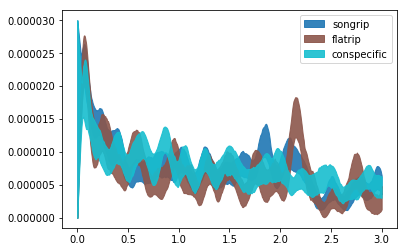

In [13]:
n_bootstraps = 100


fig, ax = plt.subplots()
cmap = plt.cm.tab10
for ii, dtype in enumerate(epochs.event_id.keys()):
    this_epochs = epochs[dtype].crop(0, 3)
    this_data = this_epochs._data.squeeze()
    this_color = cmap(float(ii) / (len(epochs.event_id.keys()) - 1))
    boot_means = np.zeros([n_bootstraps, this_data.shape[-1]])
    ixs = np.random.randint(0, len(this_data), len(this_data) * n_bootstraps).reshape([n_bootstraps, -1])
    for boot, this_ix in enumerate(ixs):
        this_boot = this_data[this_ix].mean(0)
        boot_means[boot] = this_boot
        
    clo, chi = np.percentile(boot_means, [2.5, 97.5], axis=0)
    ax.fill_between(this_epochs.times, clo, chi, color=this_color, label=dtype, alpha=.9)
ax.legend()

# Assignment 1: Calculate the noise for each trial and display it

Calculate the noise using a signal generated from all trials as well as a signal that does not incldue the trial for wich you calculate the noise

In [14]:
# Choose a very good neuron from the auditory midbrain.

this_data = data.query('quality == "good" and location == "mld" and kind=="conspecific"')

In [15]:
filt_kwargs = dict(l_freq=None, h_freq=20, verbose=False)

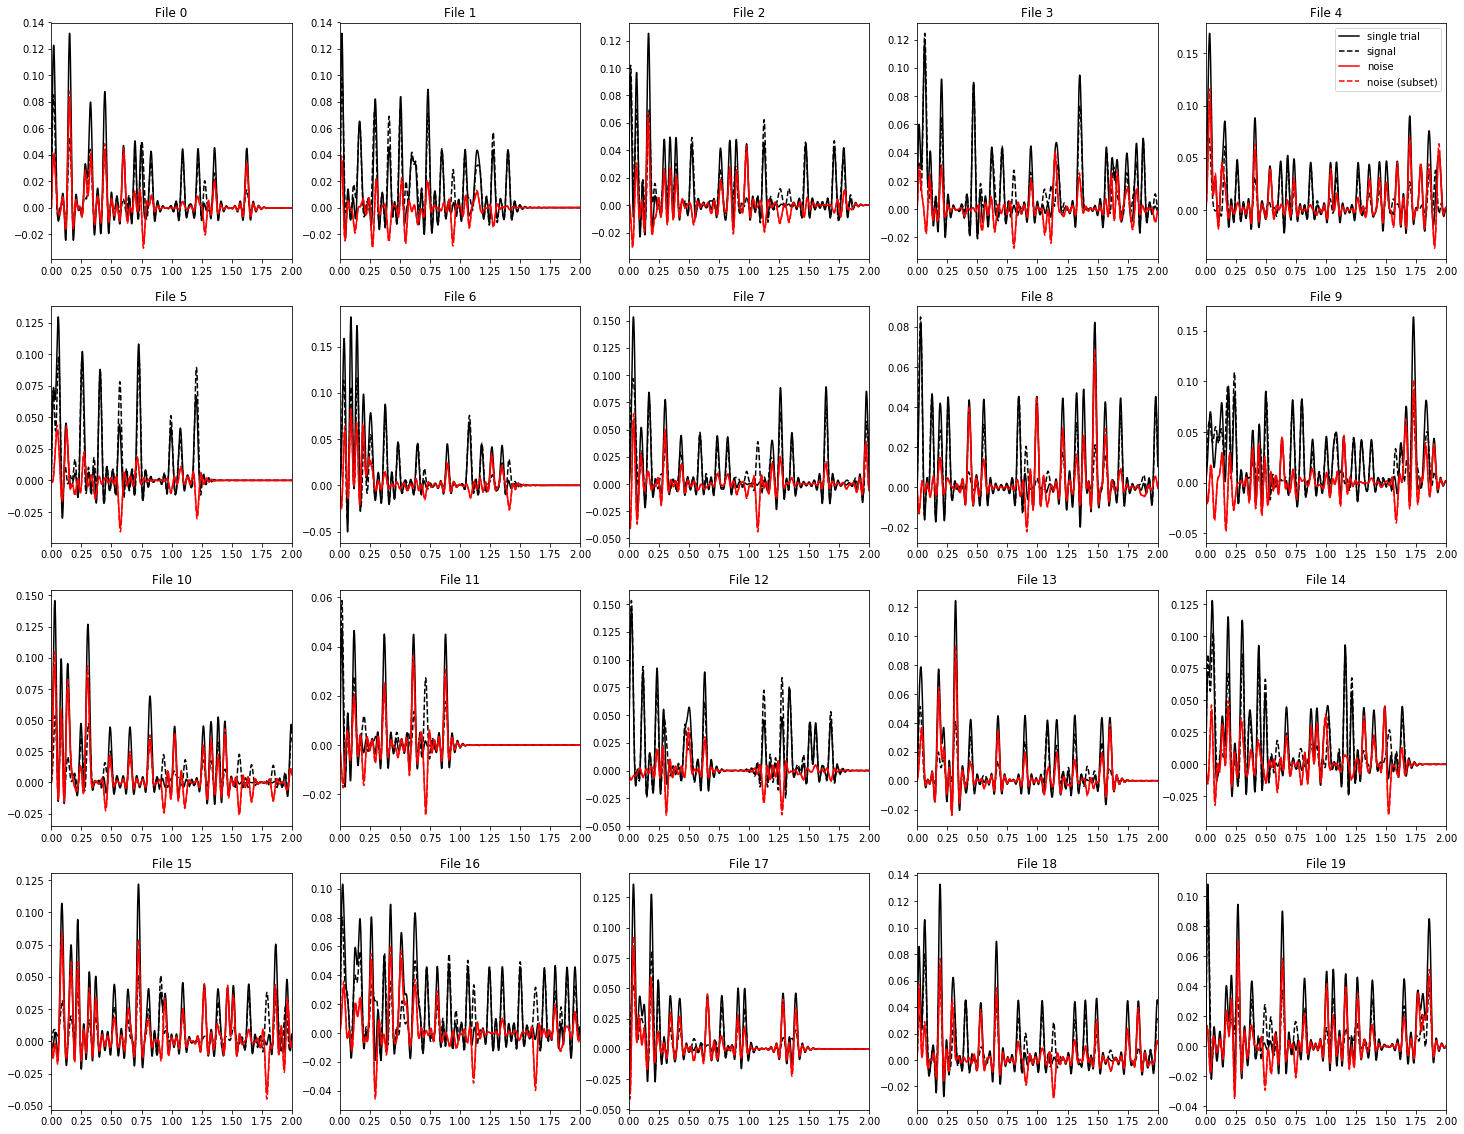

In [16]:
### Chris - we are going to have to help the students quite a bit more.  We should have some code that allows
# them to understand the data structure - I don't think we can assume they know how to use panda.

n_cols = 5
n_rows = int(np.ceil(len(this_data.groupby('path')) / n_cols))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))

noise_tot = []
noise_subset_tot = []
signal_tot = []
for iifile, ((wavfile, i_data), ax) in enumerate(zip(this_data.groupby('path'), axs.ravel())):
    
    spikes = i_data['spike_times'].values
    event_types = i_data['kind'].values

    neuron = Neuron(spikes, sfreq=1000.0, events=event_types,
                    length=5., name='neuron_{}'.format(ii))
    signal = neuron.spikes.mean(0)
    for ii, trial in enumerate(neuron.spikes):
        ixs = list(range(i_data.shape[0]))
        ixs.pop(ii)
        
        signal_subset = neuron.spikes[ixs].mean(0)
        noise_all = trial - signal
        noise_subset = trial - signal_subset
        
        noise_subset_tot.append(noise_subset)
        noise_tot.append(noise_all)
        signal_tot.append(signal)
        if ii == 0:
            ax.plot(neuron.time, mne.filter.filter_data(trial, neuron.sfreq, **filt_kwargs),
                    color='k', label='single trial')
            ax.plot(neuron.time, mne.filter.filter_data(signal, neuron.sfreq, **filt_kwargs),
                    color='k', ls='--', label='signal')
            ax.plot(neuron.time, mne.filter.filter_data(noise_all, neuron.sfreq, **filt_kwargs),
                    color='r', label='noise')
            ax.plot(neuron.time, mne.filter.filter_data(noise_subset, neuron.sfreq, **filt_kwargs),
                    color='r', ls='--', label='noise (subset)')
            ax.set(title='File {}'.format(iifile), xlim=[0, 2])
axs[0, -1].legend()

# Collect the saved signal / noise from each trial
noise_subset_tot = np.array(noise_subset_tot)
noise_tot = np.array(noise_tot)
signal_tot = np.array(signal_tot)

# Assignment 2: Calculate the noise and signal psd obtained by averaging and by averaging after JNF. Is the noise white?

In [127]:
### Chris: Here again to help the students we should have Hints - such as links to mne page - as below.

## Hint: to calculate the power spectra you can use mne's time-frequency power spectrum estimation routines.
## Eg. https://www.martinos.org/mne/stable/generated/mne.time_frequency.psd_array_welch.html#mne.time_frequency.psd_array_welch

psignal, freqs = mne.time_frequency.psd_array_welch(signal_tot, neuron.sfreq, n_overlap=125)
pnoise, freqs = mne.time_frequency.psd_array_welch(noise_tot, neuron.sfreq, n_overlap=125)
pnoise_subset, freqs = mne.time_frequency.psd_array_welch(noise_subset_tot, neuron.sfreq, n_overlap=125)

Effective window size : 0.256 (s)
Effective window size : 0.256 (s)
Effective window size : 0.256 (s)


In [130]:
print freqs.shape
print psignal.shape

(129,)
(200, 129)


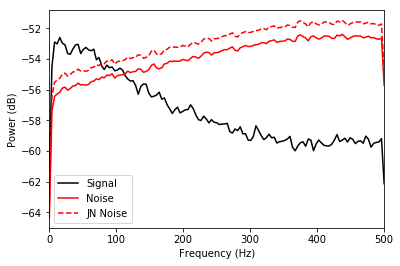

In [19]:
fig, ax = plt.subplots()
ax.plot(freqs, 10 * np.log10(psignal.mean(0)), c='k', label='Signal')
ax.plot(freqs, 10 * np.log10(pnoise.mean(0)), c='r', label='Noise')
ax.plot(freqs, 10 * np.log10(pnoise_subset.mean(0)), c='r', ls='--', label='JN Noise')

ax.set(xlim=[0, neuron.sfreq / 2], xlabel='Frequency (Hz)', ylabel='Power (dB)')
plt.legend()

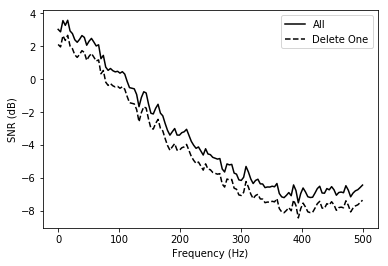

In [20]:
fig, ax = plt.subplots()
ax.plot(freqs, 10.0*np.log10(psignal.mean(0) / pnoise.mean(0)), 'k', label='All')
ax.plot(freqs, 10.0*np.log10(psignal.mean(0) / pnoise_subset.mean(0)), 'k--', label='Delete One')
ax.set(ylabel='SNR (dB)', xlabel='Frequency (Hz)')
plt.legend()

# Assignment 3: Is the noise gaussian?

### Chris: replace by hints for python.
Matlab has a nice command called histfit that generates a histogram and displays a probability density fit. The default is a normal distribution.

In [21]:
from scipy.stats import norm

noise_subset_filt = mne.filter.filter_data(noise_subset, neuron.sfreq, None, 10)
noise_mu, noise_std = norm.fit(noise_subset_filt.ravel())

Setting up low-pass filter at 10 Hz
h_trans_bandwidth chosen to be 2.5 Hz
Filter length of 2640 samples (2.640 sec) selected


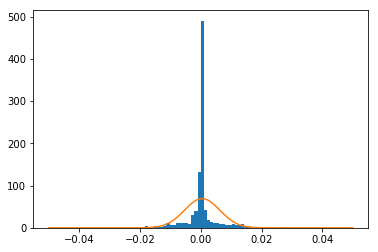

In [22]:
fig, ax = plt.subplots()
ax.hist(noise_subset_filt, bins=50, normed=True)

plt_x = np.linspace(-.05, .05, 100)
ax.plot(plt_x, norm.pdf(plt_x, noise_mu, noise_std))

# Assignment 4: Calculate and display the coherence calculated from the signal to noise ratio.

In [23]:
# The coherence is S/(S+N)
coh_snr = psignal.mean(0) / (pnoise.mean(0) + psignal.mean(0))

# The information is obtained by integrating (summing) the log2(1 - coherence).
dfreq = freqs[1] - freqs[0]      # The delta frequency
info_snr = np.sum(-np.log2(1 - coh_snr)) * dfreq

coh_snr_d1 = psignal.mean(0) / (pnoise_subset.mean(0) + psignal.mean(0))
info_snr_d1 = np.sum(-np.log2(1 - coh_snr_d1)) * dfreq

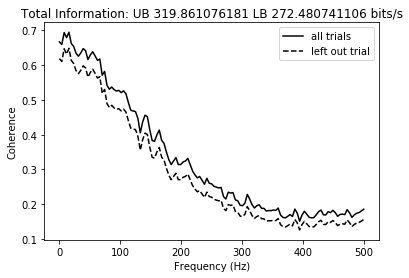

In [24]:
fig, ax = plt.subplots()
ax.plot(freqs, coh_snr, 'k', label='all trials')
ax.plot(freqs, coh_snr_d1, 'k--', label='left out trial')
ax.set(ylabel='Coherence', xlabel='Frequency (Hz)', title='Total Information: UB {} LB {} bits/s'.format(
    info_snr, info_snr_d1))
ax.legend()

We are now going to calculate the coherence and channel capacity using
Hsu, Borst, Theunissen methodology. In order to do that we need to take the raw spike times, split them into even and odd trials, and compute PSTHs for each half. there's already a function to do this, so we'll just call it.

In [25]:
spikes = []
events = []
for iifile, ((wavfile, i_data), ax) in enumerate(zip(this_data.groupby('path'), axs.ravel())):
    # Concatenate spike times / events
    spikes += list(i_data['spike_times'].values)
    events += list(i_data['kind'].values)


# Convert the spiking data into a timeseries according to the sfreq we want
neuron = Neuron(spikes, sfreq=1000.0, events=events,
                length=5., name='neuron_{}'.format(ii))
epochs = neuron.to_mne(psth=True)

200 matching events found
0 projection items activated
0 bad epochs dropped


In [26]:
ixs = np.arange(len(epochs))
epochs_odd = epochs[ixs % 2 != 0]
epochs_even = epochs[ixs % 2 == 0]

the next step is to concatenate the PSTHs across all stim/response
pairs into one big vector. we're going to do the same thing to the psth halves as well. we're also going to take note of the # of spike trials

In [27]:
all_epochs_odd = epochs_odd._data.ravel()
all_epochs_even = epochs_even._data.ravel()
all_epochs = epochs._data.ravel()

we're going to make a copy of the concatenated PSTH and corrupt
it with Gaussian noise, pretending it's a PSTH that comes from some model

In [28]:
noiseGain = 1e-3 # play with gain to increase or decrease PSTH corruption
noise = np.random.randn(all_epochs.shape) * noiseGain # make some noise!
epochs_noise = all_epochs + noise # corrupt PSTH

epochs_noise[epochs_noise < 0] = 0 # Rectify
epochs_noise[epochs_noise > 1] = 1 # Saturate

finally, we're going to compute the upper bound of coherence, as
for the cell itself, as well as the coherence between the noise- corrupted PSTH and actual PSTH

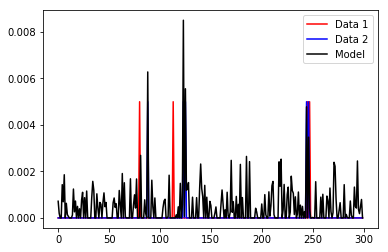

In [64]:
fig, ax = plt.subplots()
ax.plot(all_epochs_odd[200:500], 'r', label = 'Data 1')
ax.plot(all_epochs_even[200:500], 'b', label = 'Data 2')
ax.plot(epochs_noise[200:500], 'k', label = 'Model')
ax.legend()


# XXX FREDERIC XXX Can you explain what `compute_coherence_full` does?

the goal of compute_coherence_full is to calculate the 'noise-corrected' coherence between a prediction of a response (from a model) and the actual response.   It takes arguments: the prediction, the mean response, the mean response from 1/2 data, the mean response from the other 1/2 of the data, the sampling rate, the number of trials.

It them uses the equations from Hsu et al. 2004.  It gives the coherence between the prediction and the response and compares that to the maximum coherence you could expect with additive noise.  In reality these days you might do this in a more bootstrap fashion. At that time this fast too slow for the improvement in estimation.

In this exercise, the "prediction' is just a noise corrupted version of the psth (mean response).

In [155]:
# Compute coherence between the two half psths:
X = np.zeros(shape=(1, 2, all_epochs_odd.shape[0]) )
X[0,0,:] = all_epochs_odd
X[0,1,:] = all_epochs_even
csd_1_2, c_freqs = mne.time_frequency.csd_array(X, 1000.0, n_fft=512,  fsum=False, mode='fourier', fmin=-0.1, fmax=500.1)
psd_1_2, p_freqs = mne.time_frequency.psd_array_welch(X[0,:,:].squeeze(), 1000.0, n_fft=512)

coh_1_2 = np.abs(csd_1_2[0,1,:])**2 / (psd_1_2[0,0:-1] * psd_1_2[1,0:-1])


Computing cross-spectral density from array...
    using FFT with a Hanning window to estimate spectra
[done]
Effective window size : 0.512 (s)


In [162]:
np.sum(X[0,1,0:512])

0.055

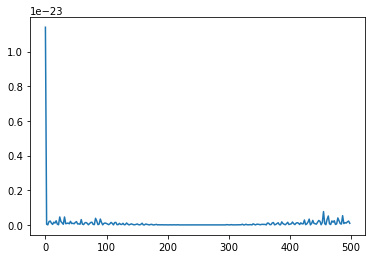

In [154]:
fig, ax = plt.subplots()
ax.plot(c_freqs, coh_1_2)

In [93]:
# Compute coherence between the two half psths:
X = np.zeros(shape=(1, 2, all_epochs_odd.shape[0]) )
X[0,0,:] = np.random.randn(all_epochs_odd.shape[0])
X[0,1,:] = np.random.randn(all_epochs_odd.shape[0])
csd_1_2, coh_freqs = mne.time_frequency.csd_array(X, 1000.0, n_fft=512,  fsum=False, mode='fourier')

coh_1_2 = np.abs(csd_1_2[0,1,:])**2 / (np.real(csd_1_2[0,0,:]) * np.real(csd_1_2[1,1,:]))

Computing cross-spectral density from array...
    using FFT with a Hanning window to estimate spectra
[done]


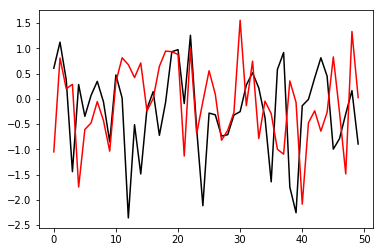

In [98]:
fig, ax = plt.subplots()
ax.plot(X[0,0,0:50],'k')
ax.plot(X[0,1,0:50],'r')

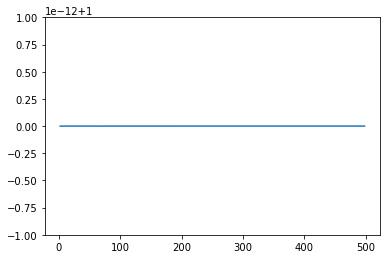

In [99]:
fig, ax = plt.subplots()
ax.plot(coh_freqs, coh_1_2)

In [120]:
np.real(csd_1_2[0,0,0:10])


array([  3.00817172e-23,   2.57050847e-23,   9.78833685e-23,
         1.00362248e-22,   5.13877705e-23,   5.17179219e-23,
         9.62746285e-23,   5.74863762e-23,   8.15905985e-23,
         3.70728951e-23])

In [121]:
np.abs(csd_1_2[0,1,0:10])**2


array([  1.34351955e-45,   1.91476186e-46,   9.35936855e-45,
         1.50051330e-44,   4.92236899e-45,   1.00587835e-45,
         6.92652044e-45,   4.63515061e-45,   1.16138966e-44,
         1.79884529e-45])

In [122]:
np.real(csd_1_2[1,1,0:10])*np.real(csd_1_2[0,0,0:10])

array([  1.34351955e-45,   1.91476186e-46,   9.35936855e-45,
         1.50051330e-44,   4.92236899e-45,   1.00587835e-45,
         6.92652044e-45,   4.63515061e-45,   1.16138966e-44,
         1.79884529e-45])

In [179]:
def coherence(x, y, fsamp, nwindow):
    npts = len(x)    
    nchunk = int(npts/nwindow)
    
    print npts, nwindow, nchunk
        
    # List to save values
    powx = []
    powy = []
    crossxy = []
    
    iend = 0
    for i in range(nchunk):
        istart = iend
        iend = istart + nwindow
        
        xchunk = x[istart:iend]
        ychunk = y[istart:iend]
        
        xf = fft(xchunk)
        yf = fft(ychunk)
        
        powx.append(xf*xf.conj()) 
        powy.append(yf*yf.conj())
        
        crossxy.append(xf*yf)
    
    freq = fftfreq(nwindow, 1.0/fsamp)
    
    pxx = np.asarray(powx).sum(0)
    pyy = np.asarray(powy).sum(0)
    cxy = np.asarray(crossxy).sum(0)
    
    coh = np.abs(cxy)**2/(pxx*pyy)
    
    return coh[0:nwindow/2], freq[0:nwindow/2]
        
    

In [180]:
coh, freq = coherence(all_epochs_odd, all_epochs_even, 1000.0, 512)

500000 512 976


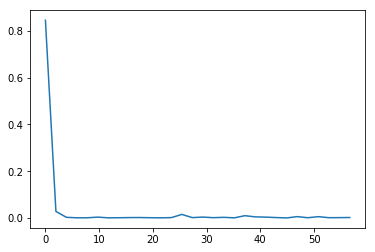

In [182]:
fig, ax = plt.subplots()
ax.plot(freq[0:30], coh[0:30])